In [1]:
# for data input and output:
import numpy as np
import os
import glob
import imageio
import time
from PIL import Image


# for deep learning: 
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Conv2DTranspose, LeakyReLU 
from keras.optimizers import Adam

# for plotting: 
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

Using TensorFlow backend.


### Loading Images

In [2]:
#save the new files to npy
#Loading Images in again 
armor = glob.glob('mhxx_800px2/*.*g')
print("Number of images: ", len(armor))

Number of images:  19487


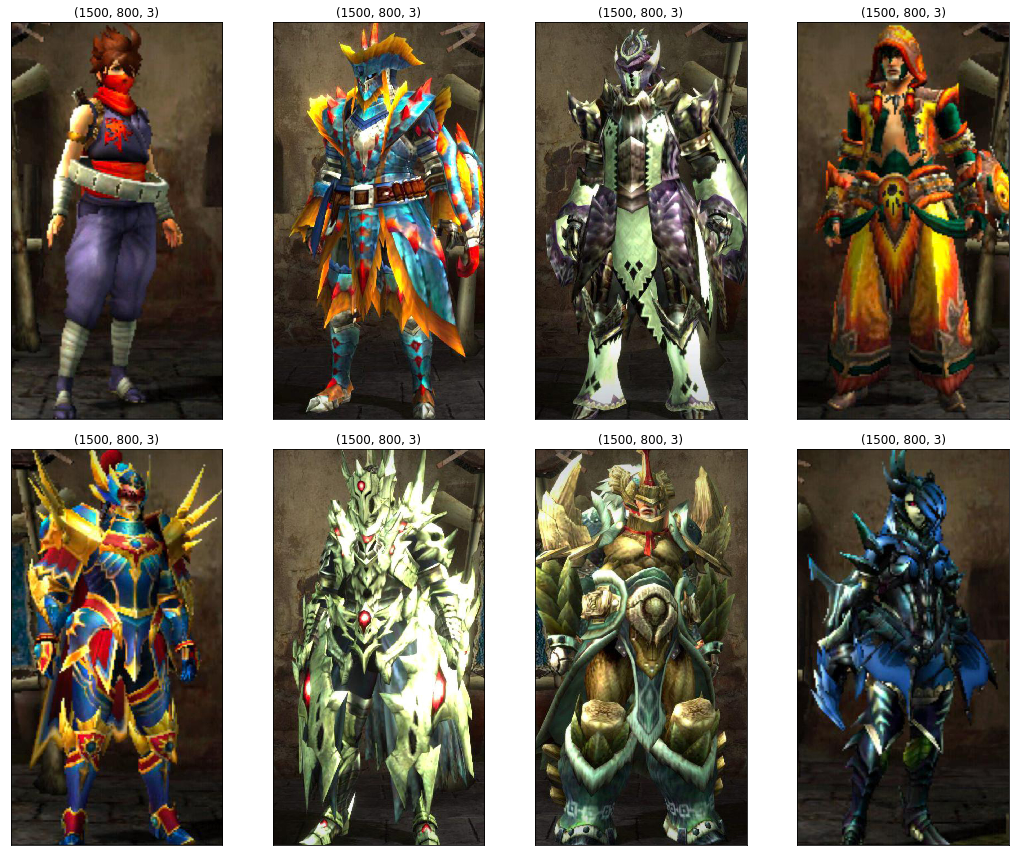

In [3]:
#using High res photo samples since dcgan isn't as picky as the styles GAN 
plt.figure(figsize = (15,12))
for i in range(8):
    img = plt.imread(armor[i+2000], 0)
    plt.subplot(2,4, i + 1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Batch Size, Number of training sets, image shape, files locations

In [40]:
# Shape of noise vector to be input to the Generator
noise_shape = (1,1,100)
# Number of steps for training. num_epochs = num_steps*batch_size/data_size
num_steps = 20000
# batch size for training.
batch_size = 64
# Location to save images and logs 
img_save_dir = "mhxx_armor/"
# Image size to reshape to
image_shape = (64,64,3)
# Location of data directory
data_dir = "mhxx_800px2/*.*g"
# set up log and save directories
log_dir = img_save_dir
save_model_dir = img_save_dir

### Building the discriminator 

In [41]:
def build_discriminator(image_shape= image_shape):
    kernel_init = 'glorot_uniform'
    dis_input = Input(shape = image_shape)
    
    # Conv layer 1:
    discriminator = Conv2D(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", kernel_initializer = kernel_init)(dis_input)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 2:
    discriminator = Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 3:   
    discriminator = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 4:
    discriminator = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Flatten
    discriminator = Flatten()(discriminator)
    # Dense Layer
    discriminator = Dense(1)(discriminator)
    # Sigmoid Activation
    discriminator = Activation('sigmoid')(discriminator)
    
    # Model definition
    discriminator_model = Model(inputs = dis_input, outputs = discriminator)
    
    return discriminator_model

In [42]:
discriminator = build_discriminator(image_shape)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)         524544    
__________

In [43]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=0.0002, beta_1=0.5), 
                      metrics=['accuracy'])

### Building generator

In [44]:
def gen_noise(batch_size, noise_shape):
    ''' Generates a numpy vector sampled from normal distribution of shape (batch_size,noise_shape)
    Input:
        batch_size : size of batch
        noise_shape: shape of noise vector, normally kept as 100 
    Output:a numpy vector sampled from normal distribution of shape (batch_size,noise_shape)     
    '''
    return np.random.normal(0, 1, size=(batch_size,)+noise_shape)

In [45]:
def build_generator(noise_shape):
    ''' This function takes as input shape of the noise vector and creates the Keras generator    architecture.
    '''
    kernel_init = 'glorot_uniform'    
    gen_input = Input(shape = noise_shape) 
    
    # Transpose 2D conv layer 1. 
    generator = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = (1,1), 
                                padding = "valid",kernel_initializer = kernel_init)(gen_input)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 2.
    generator = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), 
                                padding = "same", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 3.
    generator = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), 
                                padding = "same", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 4.
    generator = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), 
                                padding = "same", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # conv 2D layer 1.
    generator = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Final Transpose 2D conv layer 5 to generate final image. Filter size 3 for 3 image channel
    generator = Conv2DTranspose(filters = 3, kernel_size = (4,4), strides = (2,2), padding = "same", kernel_initializer = kernel_init)(generator)
    
    # Tanh activation to get final normalized image
    generator = Activation('tanh')(generator)
    
    # Model definition    
    generator_model = Model(inputs = gen_input, outputs = generator)
    
    return generator_model

In [46]:
generator = build_generator(noise_shape)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 4, 4, 512)         819712    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 256)         0         
__________

In [47]:
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00015, beta_1=0.5), metrics=['accuracy'])

### Adverserial Network

In [48]:
discriminator.trainable = False
gen_inp = Input(shape=noise_shape)


GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)

adversarial_model = Model(inputs = gen_inp, outputs = GAN_opt)

adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=Adam(lr=0.00015, beta_1=0.5), 
                          metrics=['accuracy'])


In [49]:
adversarial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 1, 100)         0         
_________________________________________________________________
model_5 (Model)              (None, 64, 64, 3)         3616771   
_________________________________________________________________
model_4 (Model)              (None, 1)                 2768321   
Total params: 6,385,092
Trainable params: 3,614,723
Non-trainable params: 2,770,369
_________________________________________________________________


### Training Function, Saving image Function, Normalization and sampling

In [15]:
#Saving the images in our computer to make a gif later 
def save_img_batch(img_batch,img_save_dir):
    '''Takes as input a image batch and a img_save_dir and saves 64 images from the batch in a 4x4 grid in the img_save_dir
    '''
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
    plt.show() 

In [16]:
# A function to normalize image pixels.
def norm_img(img):
    '''A function to Normalize Images.
    Input:
        img : Original image as numpy array.
    Output: Normailized Image as numpy array
    '''
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    '''A function to Denormailze, i.e. recreate image from normalized image
    Input:
        img : Normalized image as numpy array.
    Output: Original Image as numpy array
    '''
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 

def sample_from_dataset(batch_size, image_shape, data_dir=None):
    '''Create a batch of image samples by sampling random images from a data directory.
    Resizes the image using image_shape and normalize the images.
    Input:
        batch_size : Sample size required
        image_size : Size that Image should be resized to
        data_dir : Path of directory where training images are placed.

    Output:
        sample : batch of processed images 
    '''
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB') 
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample

In [19]:
def train(num_steps=num_steps, batch=batch_size):
    
    # Use a fixed noise vector to see how the GAN Images transition through time on a fixed noise. 
    fixed_noise = gen_noise(16,noise_shape)
    
    
    # To keep Track of losses
    avg_disc_fake_loss = []
    avg_disc_real_loss = []
    avg_GAN_loss = []
    
    # We will run for num_steps iterations
    for step in range(num_steps): 
        tot_step = step
        print("Begin step: ", tot_step)
        # to keep track of time per step
        step_begin_time = time.time() 

        # sample batch of normalized real images from dataset: 
        real_imgs_X = sample_from_dataset(batch_size, image_shape, data_dir=data_dir)
        
        # Genearate noise to send as input to the generator
        noise = gen_noise(batch_size,noise_shape)

        # Use generator to create(predict) images generates fake images:
        fake_imgs_X = generator.predict(noise)

        # Save predicted images from the generator every 200th step
        if (tot_step % 200) == 0:
            step_num = str(tot_step).zfill(4)
            save_img_batch(fake_imgs_X,img_save_dir+step_num+"_image.png")
        
        
        # Create the labels for real and fake data. We don't give exact ones and zeros but add a small amount of noise. This is an important GAN training trick
        real_imgs_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
        fake_imgs_Y = np.random.random_sample(batch_size)*0.2

        # train the discriminator using data and labels

        discriminator.trainable = True
        generator.trainable = False

        # Training Discriminator seperately on real data
        dis_metrics_real = discriminator.train_on_batch(real_imgs_X,real_imgs_Y) 
        # training Discriminator seperately on fake data
        dis_metrics_fake = discriminator.train_on_batch(fake_imgs_X,fake_imgs_Y) 

        print("Disc: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))

        # Save the losses to plot later
        avg_disc_fake_loss.append(dis_metrics_fake[0])
        avg_disc_real_loss.append(dis_metrics_real[0])
    
    
        # Train the generator using a random vector of noise and its labels (1's with noise)
        generator.trainable = True
        discriminator.trainable = False

        # adversarial net's noise input and real images y: 
        GAN_X = gen_noise(batch_size,noise_shape)
        GAN_Y = real_imgs_Y

        # train adversarial net: 
        gan_metrics = adversarial_model.train_on_batch(GAN_X,GAN_Y)
        print("GAN loss: %f" % (gan_metrics[0]))

        # Log results by opening a file in append mode
        text_file = open(log_dir+"\\training_log.txt", "a")
        text_file.write("Step: %d Disc: real loss: %f fake loss: %f GAN loss: %f\n" % (tot_step, dis_metrics_real[0], dis_metrics_fake[0],gan_metrics[0]))
        text_file.close()

        # save GAN loss to plot later
        avg_GAN_loss.append(gan_metrics[0])
            
        end_time = time.time()
        diff_time = int(end_time - step_begin_time)
        print("Step %d completed. Time took: %s secs." % (tot_step, diff_time))

        # save model at every 1000 steps
        if ((tot_step+1) % 1000) == 0:
            print("-----------------------------------------------------------------")
            print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss))) 
            print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss))) 
            print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
            print("-----------------------------------------------------------------")
            discriminator.trainable = False
            generator.trainable = False
            # predict on fixed_noise
            fixed_noise_generate = generator.predict(noise)
            step_num = str(tot_step).zfill(4)
            save_img_batch(fixed_noise_generate,img_save_dir+step_num+"fixed_image.png")
            generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch2.hdf5")
            discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch2.hdf5")
   
    return avg_disc_fake_loss, avg_disc_real_loss, avg_GAN_loss

### Calling our Training Function to Train on 20000 steps at a batch size of 64 images being saved at step 500

In [1]:
#Calling our Training function and outputting the variables to use for graph later 
avg_disc_fake_loss_complete, avg_disc_real_loss_complete, avg_GAN_loss_complete = train()

### Loss vs Steps 

In [22]:
import pandas as pd
disc_real_losspd = pd.DataFrame(avg_disc_real_loss_complete).reset_index()
disc_fake_losspd = pd.DataFrame(avg_disc_fake_loss_complete).reset_index()
GAN_losspd = pd.DataFrame(avg_GAN_loss_complete).reset_index()



In [32]:
# disc_real_losspd.to_csv('disc_real_loss.csv', index = False)
# disc_fake_losspd.to_csv('disc_fake_loss.csv', index = False)
# GAN_losspd.to_csv('GAN_loss.csv', index = False)

In [23]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=GAN_losspd['index'], y=GAN_losspd[0], name="Generator Loss",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=disc_real_losspd['index'], y=disc_real_losspd[0], name="Real Discriminator Loss",
                         line_color='green'))

fig.add_trace(go.Scatter(x=disc_fake_losspd['index'], y=disc_fake_losspd[0], name="Fake Discriminator Loss",
                         line_color='red'))

fig.update_layout(title_text='Losses vs Training steps',
                  xaxis_rangeslider_visible=True)
fig.show()

### Gif and MP4 created from png files during DCGANs training 

In [27]:
#generating gifs from png
import imageio

generated_images = [img_save_dir + str(x).zfill(4) + "_image.png" for x in range(0, num_steps,200)]

In [28]:
#saving as a gif
images = []
for filename in generated_images:
    images.append(imageio.imread(filename))

imageio.mimsave(img_save_dir+'movie.gif', images) 

In [24]:
# from IPython.display import Image
# with open("mhxx_armor/movie.gif",'rb') as f:
#     display(Image(data=f.read(), format='png'))

In [33]:
#saving as a mp4
import os
from moviepy.editor import *

clips = []

for filename in images:
    clips.append(ImageClip(filename).set_duration(0.1))
     
video = concatenate(clips, method="compose")
video.write_videofile('mhxx.mp4', fps=24)

t:   1%|          | 2/240 [00:00<00:16, 14.43it/s, now=None]

Moviepy - Building video mhxx.mp4.
Moviepy - Writing video mhxx.mp4



Moviepy - Done !
Moviepy - video ready mhxx.mp4


In [34]:
generator.save(os.path.join(img_save_dir,"generator.h5"))

In [37]:
# load weights into new model
from keras.models import load_model
model = load_model('mhxx_armor/generator.h5')